### Neural Network classification with PyTorch

In [1]:
# Create classification data
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)


In [2]:
import torch
from torch import nn
torch.__version__

'2.3.1+cu118'

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
X[:7], y[:7]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872]]),
 array([1, 1, 1, 1, 0, 1, 1], dtype=int64))

In [6]:
# Converting the data to pandas dataframe
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(7)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1


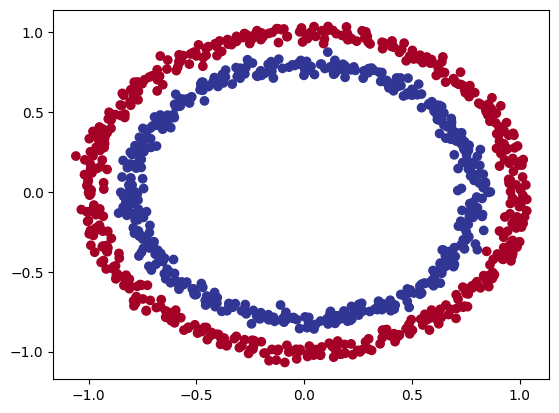

In [7]:
# Visualize the data 
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [8]:
# Turn data into PyTorch tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:7], y[:7]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033]]),
 tensor([1., 1., 1., 1., 0., 1., 1.]))

In [9]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [10]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# Consruct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Creating two dense layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

CNet_0 = CircleModelV0().to(device)
CNet_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(CNet_0.parameters()).device

device(type='cuda', index=0)

In [15]:
CNet_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2837, -0.6002],
                      [ 0.3158, -0.6810],
                      [-0.3348,  0.4243],
                      [-0.6772, -0.6163],
                      [-0.1986,  0.6637]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.1507, -0.0894,  0.6425, -0.4477,  0.2185], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.1933, -0.3049, -0.4026,  0.2268,  0.4403]], device='cuda:0')),
             ('layer_2.bias', tensor([0.2449], device='cuda:0'))])

In [16]:
# Make predictions using the untrained model
with torch.inference_mode():
    untrained_preds = CNet_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[ 0.2840],
        [ 0.2682],
        [ 0.0638],
        [ 0.3475],
        [-0.3516],
        [-0.3581],
        [-0.0734],
        [-0.2211],
        [ 0.0817],
        [ 0.2625]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
# Setup the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation built in
optimizer = torch.optim.SGD(params=CNet_0.parameters(), lr=0.1)

In [18]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Going from raw logits -> prediction probabilities -> prediction labels
We can convert the logits output by the model to prediction probabilities by passing them through an activation function, then we can convert
our model's prediction probabilities to prediction labels by either rounding them or taking the argmax.

In [19]:
CNet_0.eval()
with torch.inference_mode():
    y_logits = CNet_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2840],
        [ 0.2682],
        [ 0.0638],
        [ 0.3475],
        [-0.3516]], device='cuda:0')

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
# Use the sigmoid activation function on our model to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5705],
        [0.5666],
        [0.5160],
        [0.5860],
        [0.4130]], device='cuda:0')

In [22]:
torch.round(y_pred_probs) 
# if y_pred_probs >= 0.5, then y = 1
# if y_pred_probs < 0.5, then y = 0

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [23]:
# Combining the steps in one line of code
y_pred_labels = torch.round(torch.sigmoid(CNet_0(X_test.to(device))[:5]))
y_pred_labels, y_pred_labels.squeeze()

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>))

In [24]:
# Put data to target device(gpu)
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [25]:
# Training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    CNet_0.train()

    # Forward propagation
    y_logits = CNet_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # converting logits to prediction probabilities to prediction labels

    # Calculate the loss and accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Resets the gradients
    optimizer.zero_grad()
    
    # Implement backpropagation
    loss.backward()

    # Gradient descent
    optimizer.step()

    # Testing
    CNet_0.eval()
    with torch.inference_mode():
        # Forward propagation
        test_logits = CNet_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate the test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 10 | Loss: 0.69824, Acc: 49.25% | Test loss: 0.70118, Test acc: 51.50%
Epoch: 20 | Loss: 0.69658, Acc: 49.38% | Test loss: 0.69907, Test acc: 51.00%
Epoch: 30 | Loss: 0.69549, Acc: 49.62% | Test loss: 0.69762, Test acc: 51.00%
Epoch: 40 | Loss: 0.69475, Acc: 49.62% | Test loss: 0.69662, Test acc: 51.00%
Epoch: 50 | Loss: 0.69425, Acc: 49.38% | Test loss: 0.69592, Test acc: 51.50%
Epoch: 60 | Loss: 0.69389, Acc: 49.25% | Test loss: 0.69543, Test acc: 51.50%
Epoch: 70 | Loss: 0.69365, Acc: 49.25% | Test loss: 0.69508, Test acc: 51.50%
Epoch: 80 | Loss: 0.69347, Acc: 49.50% | Test loss: 0.69483, Test acc: 51.00%
Epoch: 90 | Loss: 0.69335, Acc: 49.62% | Test loss: 0.69466, Test acc: 51.50%
Epoch: 100 | Loss: 0.69325, Acc: 50.12% | Test loss: 0.69454, Test acc: 51.50%


In [26]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

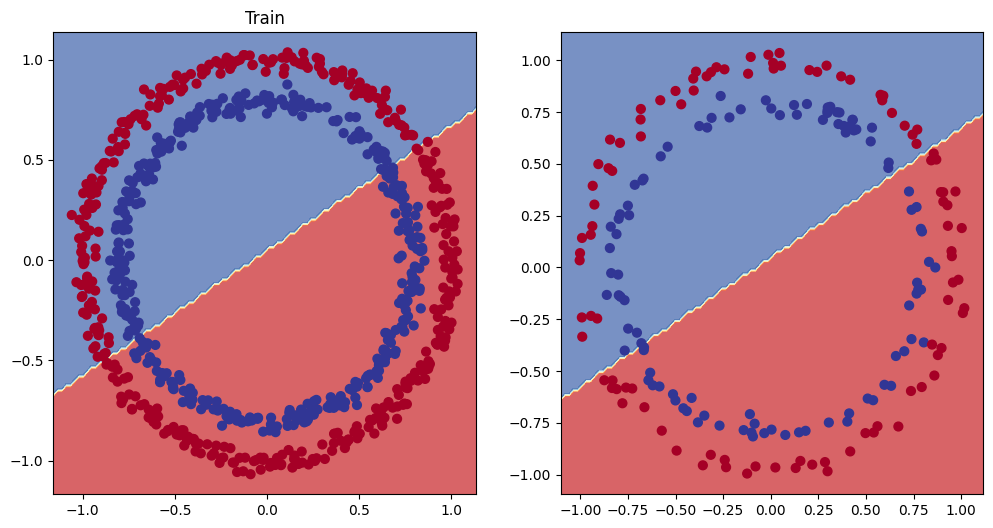

In [27]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(CNet_0, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(CNet_0, X_test, y_test)

In [28]:
# Creating a model(neural net) with non-linear activation function
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
CNet_1 = CircleModelV1().to(device)
CNet_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [29]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(CNet_1.parameters(), lr=0.1)

In [30]:
CNet_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [31]:
# Training a model with non-linearity
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1500

# Loop through data
for epoch in range(epochs):
    CNet_1.train()
    # Forward propagation
    y_logits = CNet_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits to prediction probabilities to predition labels
    # Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Gradient descent
    optimizer.step()
    # Testing 
    CNet_1.eval()
    with torch.inference_mode():
        test_logits = CNet_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    # Print out the results
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 100 | Loss: 0.6912, Acc: 53.00% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6880, Acc: 53.00% | Test Loss: 0.6873, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6842, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6811, Acc: 52.75% | Test Loss: 0.6795, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6752, Acc: 54.37% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6667, Acc: 58.38% | Test Loss: 0.6633, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6518, Acc: 64.00% | Test Loss: 0.6478, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6240, Acc: 74.00% | Test Loss: 0.6218, Test Acc: 78.50%
Epoch: 1000 | Loss: 0.5689, Acc: 87.62% | Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4825, Acc: 93.50% | Test Loss: 0.5002, Test Acc: 90.00%
Epoch: 1200 | Loss: 0.3717, Acc: 97.75% | Test Loss: 0.4069, Test Acc: 92.00%
Epoch: 1300 | Loss: 0.2556, Acc: 99.00% | Test Loss: 0.3044, Test Acc: 96

In [32]:
# Make predictions
CNet_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(CNet_1(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

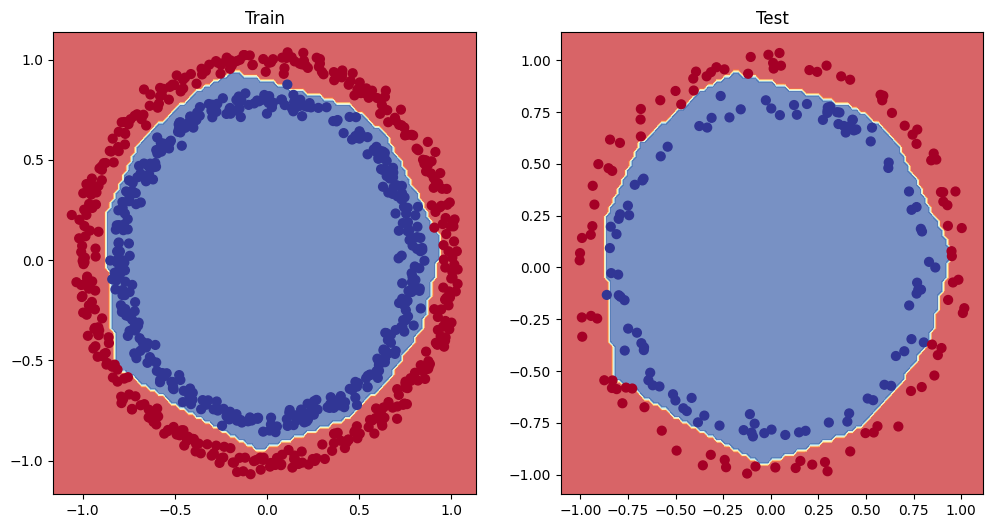

In [33]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(CNet_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(CNet_1, X_test, y_test)